In [1]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr

from glob import glob
import seaborn as sns

import numpy as np
import pandas as pd

import warnings


In [2]:
SECONDS_IN_YEAR = 60*60*24*365 #s
convert = lambda x: x * SECONDS_IN_YEAR * 1e-12 # kg -> Gt

AREA_of_EARTH = 510.1 * 1e6 #million km²

data_path = "F:\\Local Data\\ClimateBench\\"

# Only future scenarios for now
inputs = glob(data_path + "inputs_s*.nc")

def get_rmse(truth, pred):
    return np.sqrt(((truth-pred)**2))

def global_mean(ds):
    weights = np.cos(np.deg2rad(ds.latitude))
    return ds.weighted(weights).mean(['latitude', 'longitude'])

def global_sum(ds):
    weights = np.cos(np.deg2rad(ds.latitude))
    return ds.weighted(weights).sum(['latitude', 'longitude'])


In [3]:
# Get one combined historical + ssp585 timeseries for now
X = xr.open_mfdataset([data_path + 'inputs_historical.nc', data_path + 'inputs_ssp245.nc']).compute()

Y = xr.open_dataset(data_path + 'outputs_ssp245.nc')

# Convert the precip values to mm/day
Y["pr"] *= 86400
Y["pr90"] *= 86400

In [4]:
proj = ccrs.PlateCarree()

In [5]:
variables = ['tas', 'diurnal_temperature_range', 'pr', 'pr90']
# rf_predictions = xr.open_dataset(data_path + 'outputs_ssp245_predict_RF.nc')
rf_predictions = xr.open_dataset(data_path + 'outputs_ssp245_prediction_ESEm.nc')
rf_predictions = rf_predictions.assign_coords(time=rf_predictions.time+2015)
linear_predictions = xr.open_dataset(data_path + 'outputs_ssp245_prediction_pattern2.nc')
nn_predictions = xr.merge([{v: xr.open_dataarray(data_path + "outputs_ssp245_predict_{}.nc".format(v))} for v in variables])
gp_predictions = xr.merge([{v: xr.open_dataarray(data_path + "outputs_ssp245_predict_gp_{}.nc".format(v))} for v in variables])

In [6]:
# Convert the precip values to mm/day
nn_predictions["pr"] *= 86400
nn_predictions["pr90"] *= 86400

In [7]:
models = [linear_predictions, rf_predictions, nn_predictions, gp_predictions, Y]
model_labels = ['Linear', 'Random Forest', "Neural Network", 'Gaussian Process', 'NorESM2']
labels = ["Temperature (K)", "Diurnal temperature range (K)", "Precipitation (mm/day)", "Extreme precipitation (mm/day)"]
kwargs = [dict(cmap="coolwarm", vmax=6), dict(cmap="coolwarm", vmin=-4, vmax=4), dict(cmap="BrBG", vmin=-4, vmax=4), dict(cmap="BrBG", vmin=-8, vmax=8)]

[[<GeoAxesSubplot:> <GeoAxesSubplot:> <GeoAxesSubplot:> <GeoAxesSubplot:>
  <GeoAxesSubplot:>]
 [<GeoAxesSubplot:> <GeoAxesSubplot:> <GeoAxesSubplot:> <GeoAxesSubplot:>
  <GeoAxesSubplot:>]
 [<GeoAxesSubplot:> <GeoAxesSubplot:> <GeoAxesSubplot:> <GeoAxesSubplot:>
  <GeoAxesSubplot:>]
 [<GeoAxesSubplot:> <GeoAxesSubplot:> <GeoAxesSubplot:> <GeoAxesSubplot:>
  <GeoAxesSubplot:>]]


C:\Users\duncan\miniconda3\envs\climatebench\lib\site-packages\cartopy\crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
C:\Users\duncan\miniconda3\envs\climatebench\lib\site-packages\cartopy\crs.py:836: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  line_strings = list(multi_line_string)
C:\Users\duncan\miniconda3\envs\climatebench\lib\site-packages\cartopy\crs.py:836: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  line_strings = list(multi_line_string)
C:\Users\du

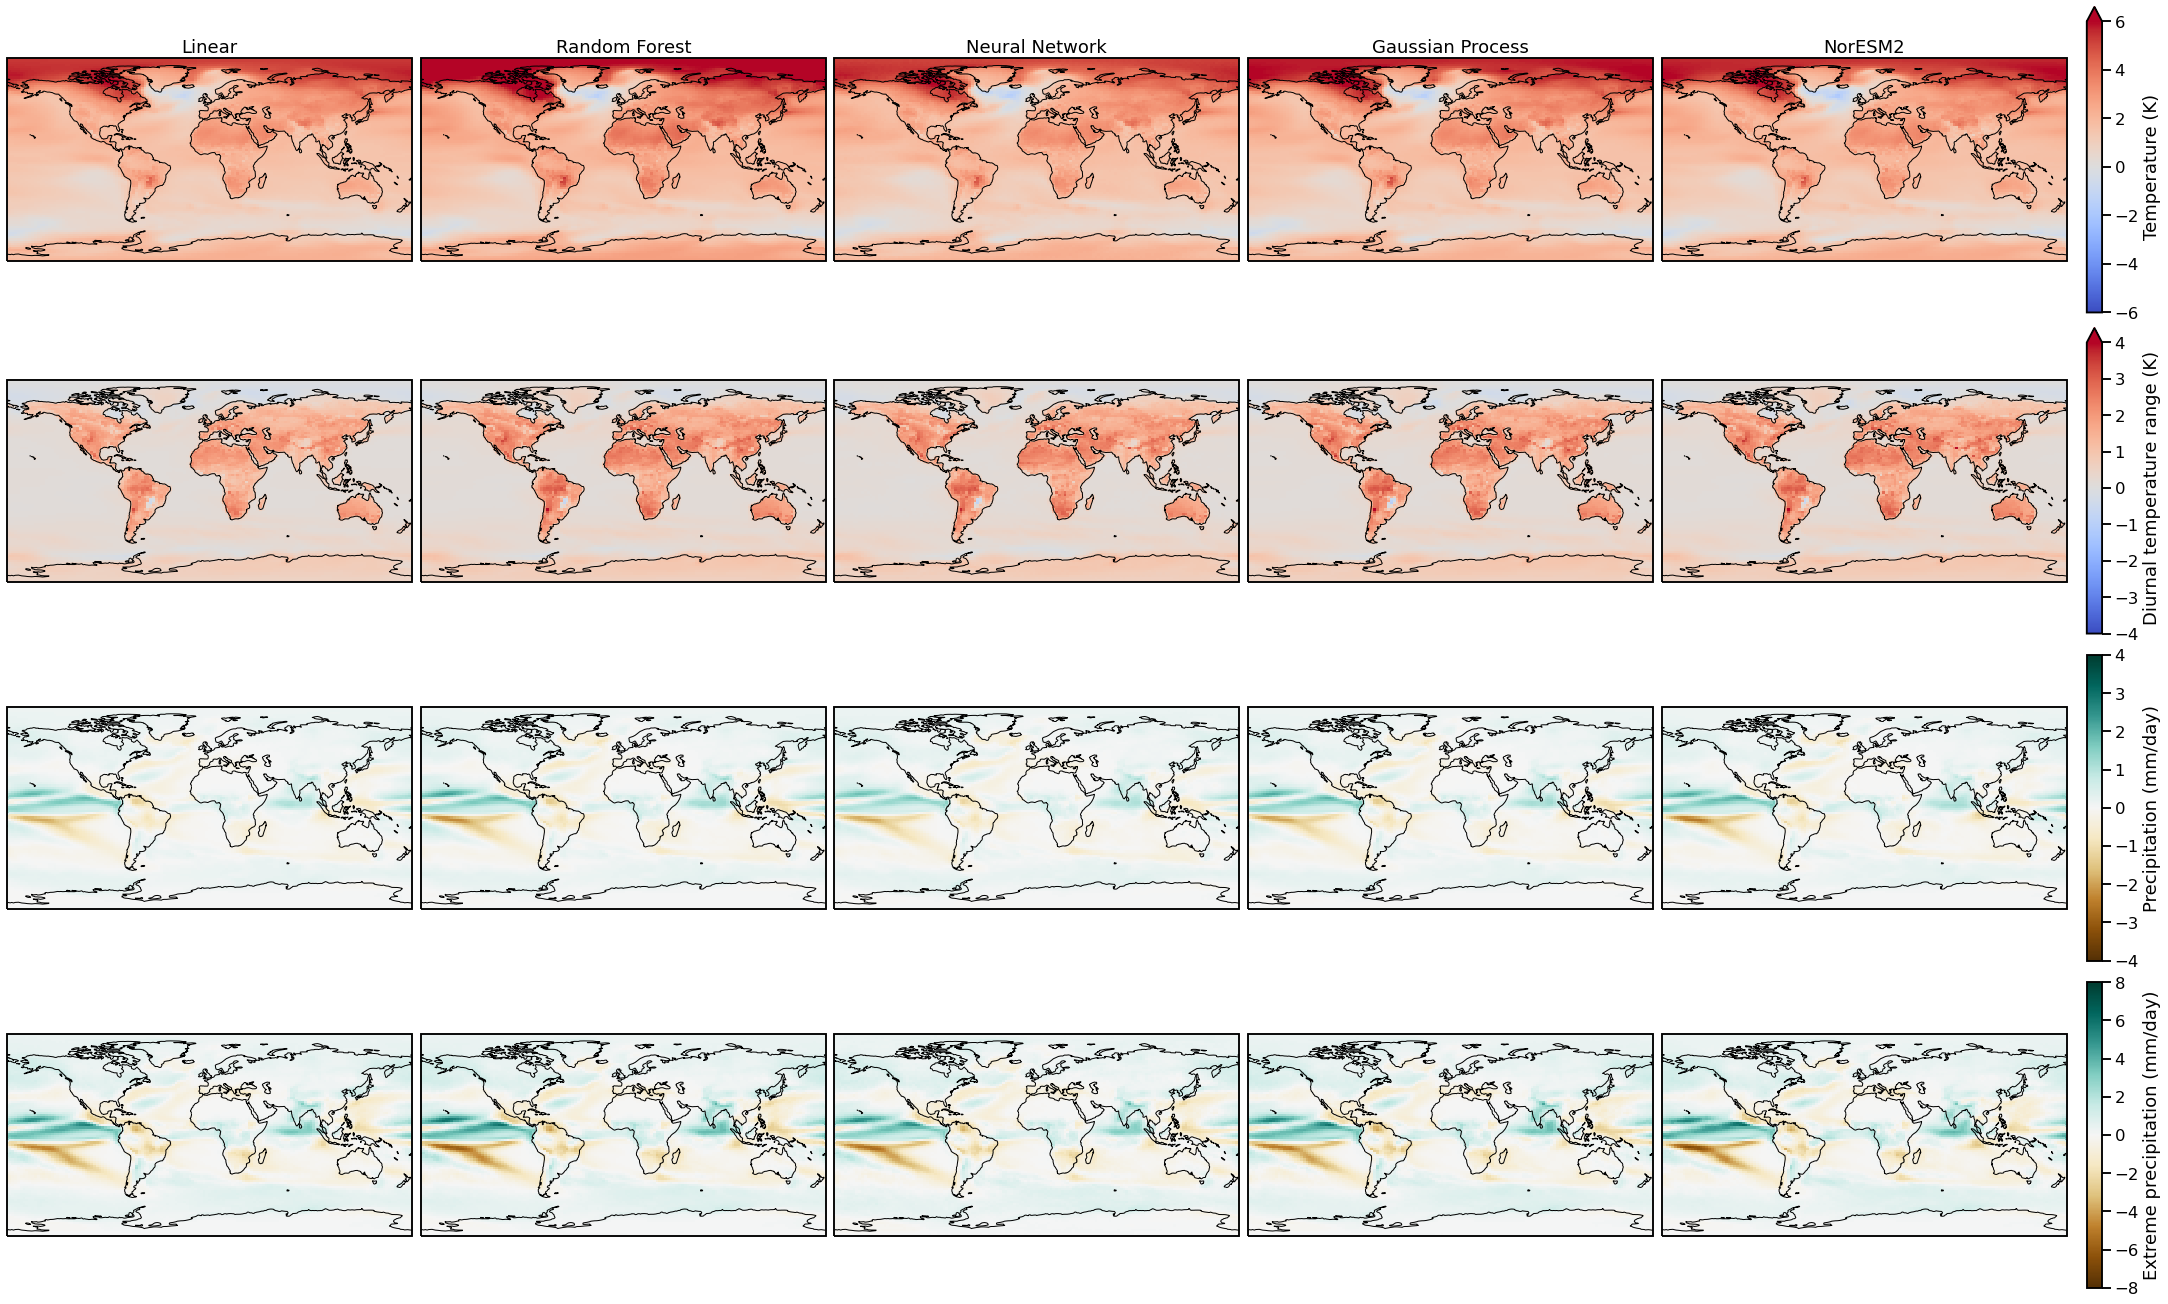

In [8]:
with sns.plotting_context("talk"):

#     fig = plt.figure()
    fig, axes = plt.subplots(4, 5, subplot_kw=dict(projection=proj), figsize=(30, 18), constrained_layout=True)
    print(axes)
    for model_axes, var, label, kws in zip(axes, variables, labels, kwargs):
        for ax, model, model_label in zip(model_axes, models, model_labels):
            if label == 'Temperature (K)':
                ax.set_title(model_label)
            if model_label == 'NorESM2':
                model[var].sel(time=slice(2050, 2100)).mean(['time', 'member']).plot(ax=ax, add_labels=False, transform=ccrs.PlateCarree(), cbar_kwargs={"label":label, "orientation":'vertical'}, **kws)
            else: 
                model[var].sel(time=slice(2050, 2100)).mean('time').plot(ax=ax, add_labels=False, transform=ccrs.PlateCarree(), add_colorbar=False, **kws)
            ax.coastlines()
                

[[<GeoAxesSubplot:> <GeoAxesSubplot:> <GeoAxesSubplot:> <GeoAxesSubplot:>]
 [<GeoAxesSubplot:> <GeoAxesSubplot:> <GeoAxesSubplot:> <GeoAxesSubplot:>]
 [<GeoAxesSubplot:> <GeoAxesSubplot:> <GeoAxesSubplot:> <GeoAxesSubplot:>]
 [<GeoAxesSubplot:> <GeoAxesSubplot:> <GeoAxesSubplot:> <GeoAxesSubplot:>]]


C:\Users\duncan\miniconda3\envs\climatebench\lib\site-packages\cartopy\crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
C:\Users\duncan\miniconda3\envs\climatebench\lib\site-packages\cartopy\crs.py:836: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  line_strings = list(multi_line_string)
C:\Users\duncan\miniconda3\envs\climatebench\lib\site-packages\cartopy\crs.py:836: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  line_strings = list(multi_line_string)
C:\Users\du

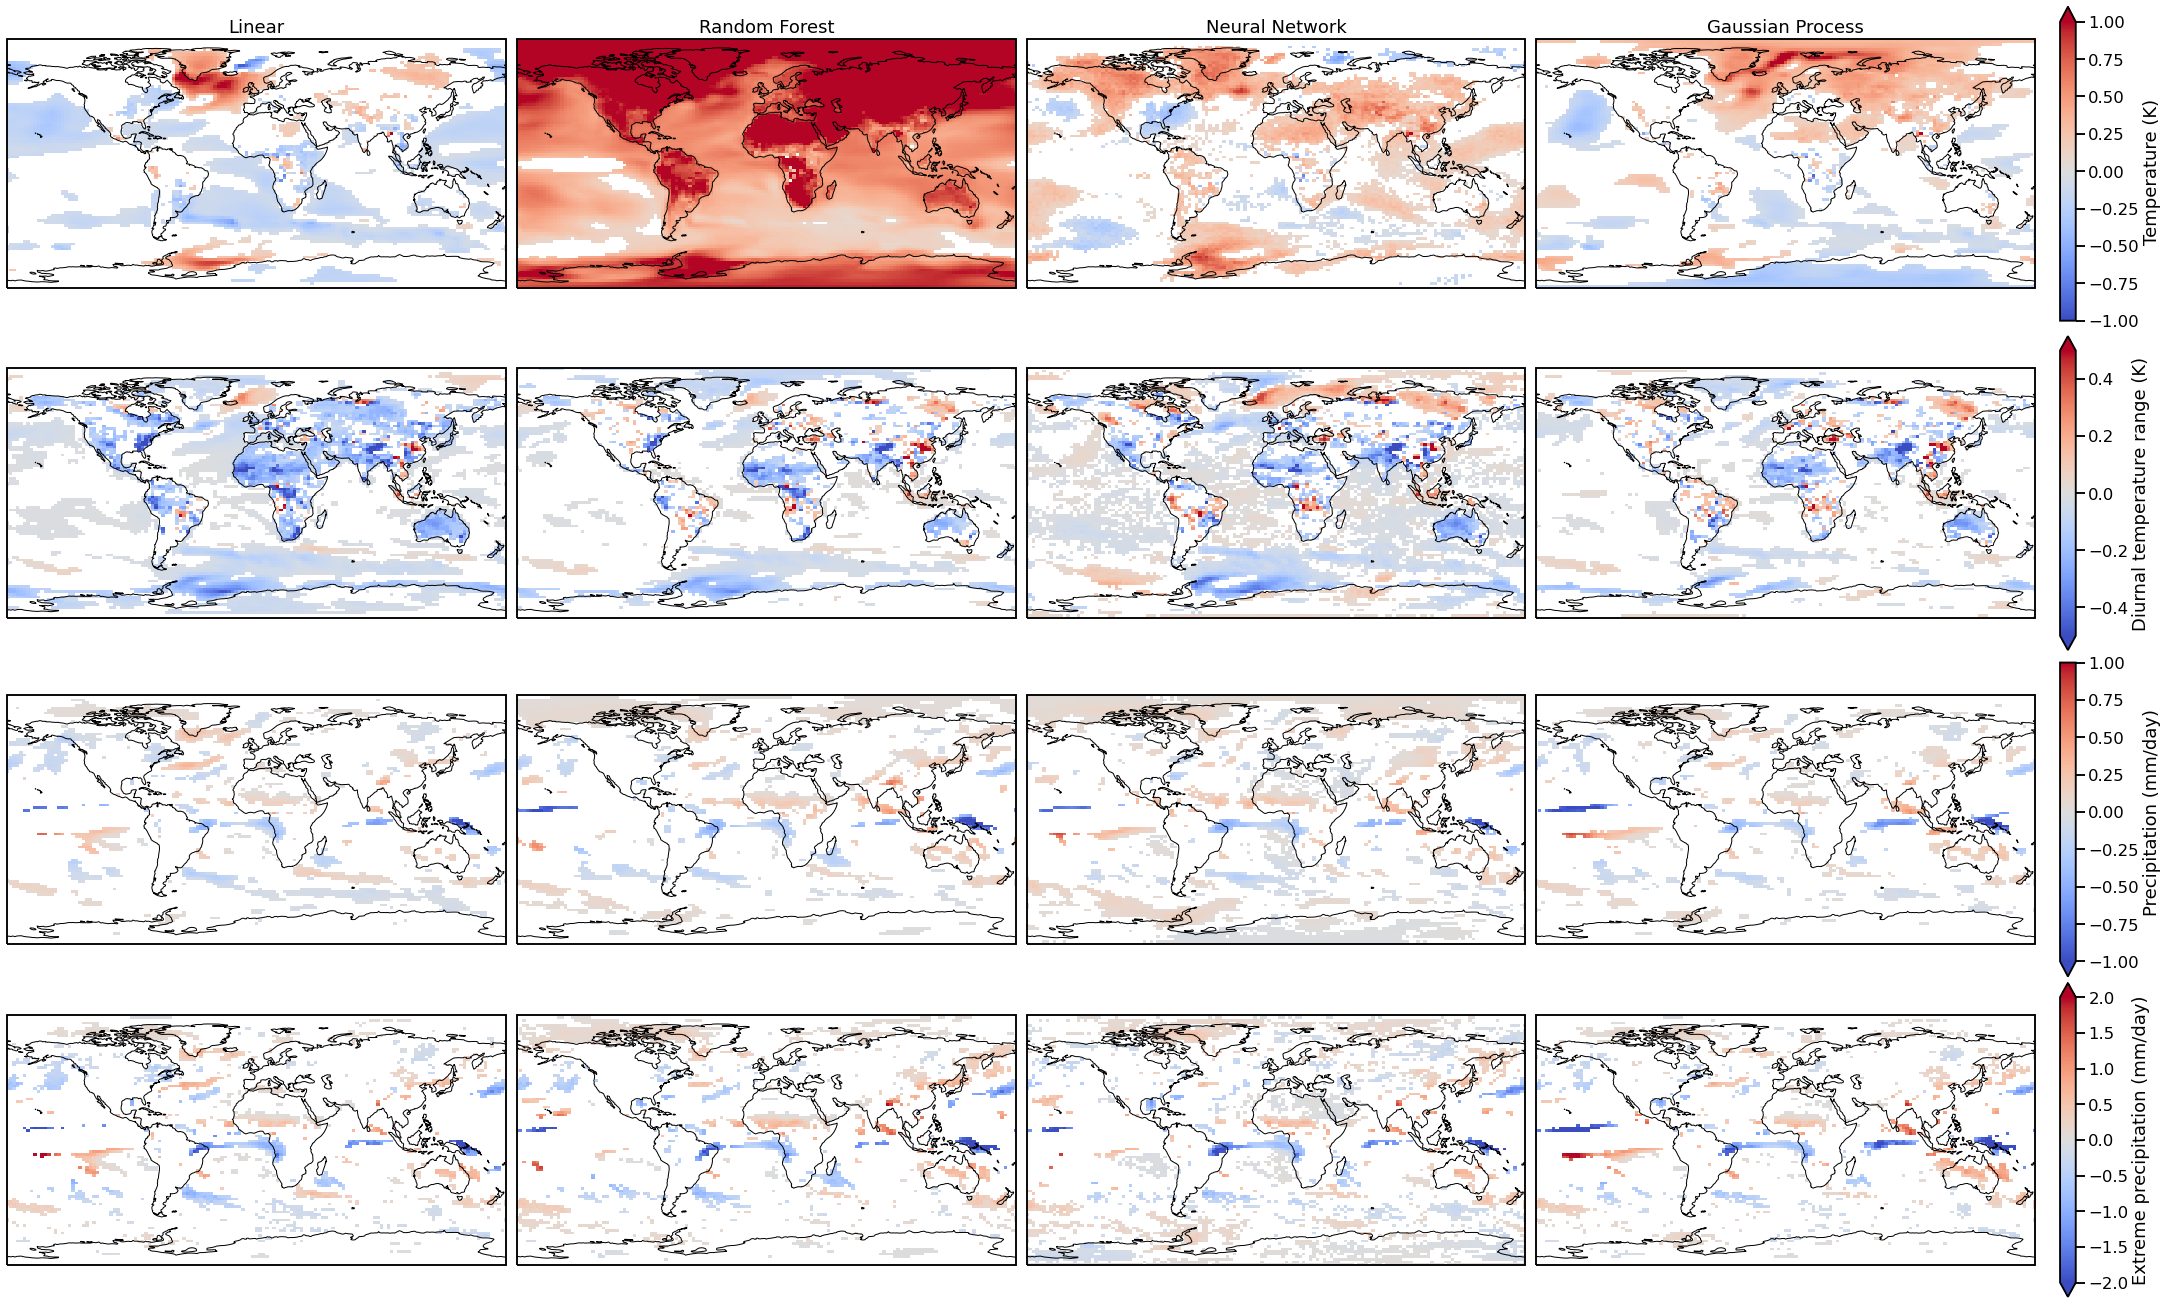

In [9]:
def ttest_rel_from_stats(diff_mean, diff_std, diff_num):
    """
    Calculates the T-test for the means of *two independent* samples of scores.

    This is a two-sided test for the null hypothesis that 2 independent samples
    have identical average (expected) values. This test assumes that the
    populations have identical variances by default.

    It is deliberately similar in interface to the other scipy.stats.ttest_... routines

    See e.g. https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind_from_stats.html
    and pg. 140 in Statistical methods in Atmos Sciences
    
    :param diff: The mean difference, x_d (|x1 - x1| == |x1| - |x2|)
    :param diff_std: The standard deviation in the difference, s_d (sqrt(Var[x_d]))
    :param diff_num: The number of points, n (n == n1 == n2)
    :return float, float: t-statistic, p-value
    """
    from scipy.stats import distributions

    z = diff_mean / np.sqrt(diff_std ** 2 / diff_num)
    # use np.abs to get upper tail, then multiply by two as this is a two-tailed test
    p = distributions.t.sf(np.abs(z), diff_num - 1) * 2
    return z, p

p_level = 0.05

# proj = ccrs.PlateCarree()
kwargs = [dict(vmin=-1, vmax=1), dict(vmin=-0.5, vmax=0.5), dict(vmin=-1, vmax=1), dict(vmin=-2, vmax=2)]


with sns.plotting_context("talk"):

#     fig = plt.figure()
    fig, axes = plt.subplots(4, 4, subplot_kw=dict(projection=proj), figsize=(30, 18), constrained_layout=True)
    print(axes)
    for model_axes, var, label, kws in zip(axes, variables, labels, kwargs):
        for ax, model, model_label in zip(model_axes, models[:-1], model_labels[:-1]):
            if label == 'Temperature (K)':
                ax.set_title(model_label)
            diff = (model[var]-models[-1][var].mean('member')).sel(time=slice(2080, 2100)) # /models[-1][var]
            mean_diff = diff.mean('time')
            _, p = ttest_rel_from_stats(mean_diff, diff.std('time'), diff.count('time'))
#             p=0
            if model_label == 'Gaussian Process':
                mean_diff.where(p < p_level).plot(cmap="coolwarm", ax=ax, add_labels=False, transform=ccrs.PlateCarree(), cbar_kwargs={"label":label, "orientation":'vertical'}, **kws)
            else:
                mean_diff.where(p < p_level).plot(cmap="coolwarm", ax=ax, add_labels=False, transform=ccrs.PlateCarree(), add_colorbar=False, **kws)
            
            ax.coastlines()
                

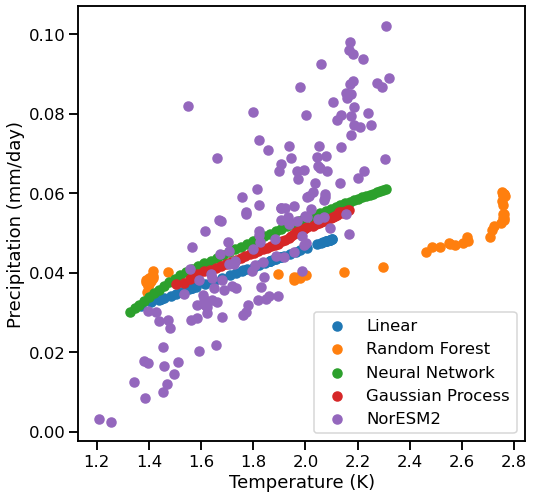

In [10]:
# models = [linear rf_predictions, nn_predictions, gp_predictions, Y.mean('member')]
# model_labels = ['Random Forest', "Neural Network", 'Gaussian Process', 'NorESM2']

def global_mean(ds):
    if 'lat' not in ds.coords:
        ds_ = ds.rename({'latitude': 'lat', 'longitude': 'lon'})
    else:
        ds_ = ds
    weights = np.cos(np.deg2rad(ds_.lat))
    return ds_.weighted(weights).mean(['lat', 'lon'])

with sns.plotting_context("talk"):

    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    for model, model_label in zip(models, model_labels):
        ax.scatter(global_mean(model['tas'].sel(time=slice(2050, 2100))), global_mean(model['pr'].sel(time=slice(2050, 2100))), label=model_label)
    plt.setp(plt.gca(), xlabel="Temperature (K)", ylabel="Precipitation (mm/day)")
    plt.legend()
                

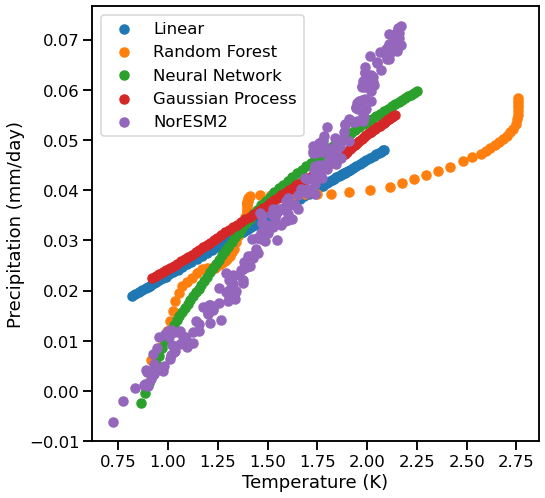

In [11]:
with sns.plotting_context("talk"):

    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    for model, model_label in zip(models, model_labels):
        ax.scatter(global_mean(model['tas']).rolling(time=10, center=True).mean(), global_mean(model['pr']).rolling(time=10, center=True).mean(), label=model_label)
    plt.setp(plt.gca(), xlabel="Temperature (K)", ylabel="Precipitation (mm/day)")
    plt.legend()

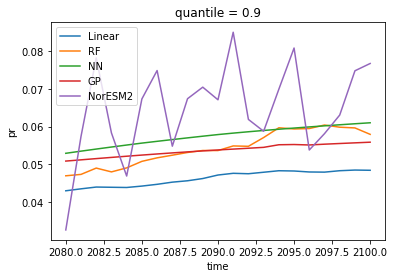

In [50]:
global_mean(linear_predictions['pr']).sel(time=slice(2080, None)).plot(label='Linear')
global_mean(rf_predictions['pr']).sel(time=slice(2080, None)).plot(label='RF')
global_mean(nn_predictions['pr']).sel(time=slice(2080, None)).plot(label='NN')
global_mean(gp_predictions['pr']).sel(time=slice(2080, None)).plot(label='GP')
global_mean(Y['pr'].mean('member')).sel(time=slice(2080, None)).plot(label='NorESM2')
plt.legend()

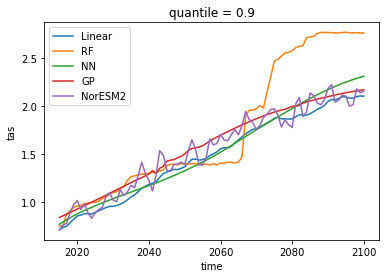

In [13]:
global_mean(linear_predictions['tas']).plot(label='Linear')
global_mean(rf_predictions['tas']).plot(label='RF')
global_mean(nn_predictions['tas']).plot(label='NN')
global_mean(gp_predictions['tas']).plot(label='GP')
global_mean(Y['tas'].mean('member')).plot(label='NorESM2')
plt.legend()

# Metrics

In [54]:
from xskillscore import rmse, pearson_r, spearman_r, r2, smape, mae, me

In [36]:
weights = np.cos(np.deg2rad(Y.mean('member')['tas'].lat)).expand_dims(lon=144).assign_coords(lon=Y.lon)

def get_rmse(truth, pred):
    return np.sqrt(global_mean((truth-pred)**2))

def get_mae(truth, pred):
    return global_mean(np.abs(truth-pred))


In [16]:
# Unweighted xskillscore
rmse(linear_predictions['tas'].sel(time=slice(2080, None)), Y.mean('member')['tas'].sel(time=slice(2080, None)))

<xarray.DataArray 'tas' ()>
array(0.41079)
Coordinates:
    quantile  float64 ...

In [44]:
# Weighted R2 of time mean variables
pd.DataFrame({
    label: {variable: r2(Y.mean('member')[variable].sel(time=slice(2080, None)).mean('time'), 
                               model[variable].sel(time=slice(2080, None)).mean('time'), weights=weights).data for variable in variables} 
    for label, model in zip(model_labels[:-1], models[:-1])
}).T.style.highlight_max(axis = 0, props='font-weight: bold')

,tas,diurnal_temperature_range,pr,pr90
Linear,0.9792885098220817,0.9795774218660029,0.9183693740429281,0.9158137959126207
Random Forest,0.5174849814915007,0.986219855312481,0.8943716693232512,0.9073366919456637
Neural Network,0.9706550085750966,0.9821285575319907,0.8976656705968746,0.9096100783902411
Gaussian Process,0.9792537333251565,0.9857263278449457,0.8875141015278967,0.8867592815027167


In [47]:
# Weighted R2 of time mean variables
pd.DataFrame({
    label: {variable: smape(Y.mean('member')[variable].sel(time=slice(2080, None)).mean('time'), 
                               model[variable].sel(time=slice(2080, None)).mean('time'), weights=weights).data for variable in variables} 
    for label, model in zip(model_labels[:-1], models[:-1])
}).T.style.highlight_min(axis = 0, props='font-weight: bold')

,tas,diurnal_temperature_range,pr,pr90
Linear,0.04753439047126907,0.052924716247279575,0.2413615106304774,0.23755619272617118
Random Forest,0.14495946612423147,0.04177596731403054,0.2508687016479225,0.23782662303794488
Neural Network,0.050964168659222174,0.06920584164528842,0.2741149330417197,0.2595846683664335
Gaussian Process,0.04384559063292837,0.03819019629529991,0.24382194537224625,0.24083949660016363


In [17]:
# time-mean RMSE of Global mean variables
pd.DataFrame({
    label: {variable: rmse(global_mean(Y.mean('member')[variable].sel(time=slice(2080, None))), 
                               global_mean(model[variable].sel(time=slice(2080, None)))).data for variable in variables} 
    for label, model in zip(model_labels[:-1], models[:-1])
}).T.style.highlight_min(axis = 0, props='font-weight: bold')

,tas,diurnal_temperature_range,pr,pr90
Linear,0.09933200445741729,0.052832011393112506,0.021548751534221155,0.06367673256516296
Random Forest,0.6686136821300575,0.022529621611345037,0.015264236795885604,0.056167680477835095
Neural Network,0.13827093196226645,0.023318255778609933,0.013301503244935417,0.06357938352356524
Gaussian Process,0.09097463434093825,0.017845907226870752,0.015863535303134915,0.051373302804458


In [41]:
# Weighted RMSE of time mean variables
pd.DataFrame({
    label: {variable: rmse(Y.mean('member')[variable].sel(time=slice(2080, None)).mean('time'), 
                               model[variable].sel(time=slice(2080, None)).mean('time'), weights=weights).data for variable in variables} 
    for label, model in zip(model_labels[:-1], models[:-1])
}).T.style.highlight_min(axis = 0, props='font-weight: bold')

,tas,diurnal_temperature_range,pr,pr90
Linear,0.16576820890253613,0.11012665950729714,0.13069428818083528,0.3710180302452523
Random Forest,0.8001123780523162,0.09046155972672658,0.14866894259957159,0.3892498479939259
Neural Network,0.19731611905580457,0.1030189185285642,0.14633247507805588,0.3844453004482925
Gaussian Process,0.16590732056625676,0.09206722249706298,0.1534189779191704,0.4303044720239118


In [55]:
# Weighted MAE of time mean variables
pd.DataFrame({
    label: {variable: mae(Y.mean('member')[variable].sel(time=slice(2080, None)).mean('time'), 
                               model[variable].sel(time=slice(2080, None)).mean('time'), weights=weights).data for variable in variables} 
    for label, model in zip(model_labels[:-1], models[:-1])
}).T.style.highlight_min(axis = 0, props='font-weight: bold')

,tas,diurnal_temperature_range,pr,pr90
Linear,0.121855061740677,0.05840937057030542,0.07785360311464096,0.23040441229321165
Random Forest,0.6640391523222744,0.04182724568988852,0.08499735732542672,0.23845681591288118
Neural Network,0.14573495039454198,0.0554561461335246,0.08846816081865744,0.2401265310541713
Gaussian Process,0.11385025851549302,0.041458620416350456,0.08246695412003369,0.24617844618747187


In [57]:
#### OK, I think this is the one to go for since it highlights the global mean discrepencies. Not sure if / how to use RMSE too?
##
# Weighted ME of time mean variables
pd.DataFrame({
    label: {variable: np.abs(me(Y.mean('member')[variable].sel(time=slice(2080, None)).mean('time'), 
                               model[variable].sel(time=slice(2080, None)).mean('time'), weights=weights).data) for variable in variables} 
    for label, model in zip(model_labels[:-1], models[:-1])
}).T.style.highlight_min(axis = 0, props='font-weight: bold')

,tas,diurnal_temperature_range,pr,pr90
Linear,0.050822,0.047680,0.018359,0.042866
Random Forest,0.663820,0.018881,0.010432,0.030492
Neural Network,0.099287,0.021329,0.007148,0.042840
Gaussian Process,0.030984,0.014628,0.010987,0.019800


In [43]:
# Weighted time-mean-RMSE
pd.DataFrame({
    label: {variable: rmse(model[variable].sel(time=slice(2080, None)), 
                               Y.mean('member')[variable].sel(time=slice(2080, None)), dim=['lat', 'lon'], weights=weights).mean('time').data for variable in variables} 
    for label, model in zip(model_labels[:-1], models[:-1])
}).T.style.highlight_min(axis = 0, props='font-weight: bold')

,tas,diurnal_temperature_range,pr,pr90
Linear,0.3667861206383514,0.16803025987754416,0.5627954036499693,1.6132958492991363
Random Forest,0.8632432086561034,0.15718450412182933,0.5719490039888769,1.6162626798109012
Neural Network,0.3837090457170353,0.1616109101437558,0.5657933643441783,1.617682430461853
Gaussian Process,0.3688860024475876,0.15649051982996007,0.5681702417700297,1.6320636098024424


In [21]:
# # Weighted time-summed-RMSE. This is the same above because they all have the number of samples it all just gets multiplied by 20
# pd.DataFrame({
#     label: {variable: get_rmse(model[variable].sel(time=slice(2080, None)), 
#                                Y.mean('member')[variable].sel(time=slice(2080, None))).sum('time').data for variable in variables} 
#     for label, model in zip(model_labels[:-1], models[:-1])
# }).T.style.highlight_min(axis = 0, props='font-weight: bold')

In [22]:
pd.DataFrame({
    label: {variable: pearson_r(model[variable].sel(time=slice(2080, None)).mean('time'), 
                               Y.mean('member')[variable].sel(time=slice(2080, None)).mean('time')).data for variable in variables} 
    for label, model in zip(model_labels[:-1], models[:-1])
}).T.style.highlight_max(axis = 0, props='font-weight: bold')

,tas,diurnal_temperature_range,pr,pr90
Linear,0.9939336203576514,0.9938021546743575,0.9609061561072987,0.9587738878673299
Random Forest,0.9912674512290055,0.9934665497666799,0.9487029193523524,0.9546051047751595
Neural Network,0.9929041862487793,0.9907780289649963,0.9493634234746321,0.9532958030333634
Gaussian Process,0.9929890410814344,0.9931597259427587,0.9444822223128732,0.9433200305262492


In [23]:
pd.DataFrame({
    label: {variable: spearman_r(model[variable].sel(time=slice(2080, None)).mean('time'), 
                               Y.mean('member')[variable].sel(time=slice(2080, None)).mean('time')).data for variable in variables} 
    for label, model in zip(model_labels[:-1], models[:-1])
}).T.style.highlight_max(axis = 0, props='font-weight: bold')

,tas,diurnal_temperature_range,pr,pr90
Linear,0.9916791821475902,0.9936801355317262,0.9433143968096918,0.9362385341366859
Random Forest,0.9879652564826483,0.9942073570072087,0.9341997984979359,0.9336123501082626
Neural Network,0.9891768680432417,0.9840215025570549,0.9317522606060137,0.9283713759094846
Gaussian Process,0.989498057657446,0.9941487784187027,0.9362677444438199,0.9286449939398583
